In [7]:
# Step 1: Import Library yang Diperlukan
from google.colab import drive
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Step 2: Mount Google Drive dan Load Dataset
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Online Retail.xlsx'
data = pd.read_excel(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Step 3: Praproses Data
# Menghapus baris dengan nilai yang hilang di 'CustomerID'
data = data.dropna(subset=['CustomerID'])

# Menambahkan fitur 'TotalPrice' sebagai Quantity * UnitPrice
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Agregasi data berdasarkan CustomerID untuk clustering per pelanggan
customer_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

# Normalisasi fitur
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['Quantity', 'TotalPrice']])

In [10]:
# Step 4: Pipeline Clustering dengan 3 Model
# Definisikan model clustering
kmeans = KMeans(n_clusters=3, random_state=42)
dbscan = DBSCAN(eps=0.5, min_samples=5)
agg_clust = AgglomerativeClustering(n_clusters=3)

# Menggabungkan model clustering dalam sebuah list
models = [kmeans, dbscan, agg_clust]
model_names = ['KMeans', 'DBSCAN', 'AgglomerativeClustering']

# Fungsi untuk menampilkan evaluasi clustering
def evaluate_clustering(model, data, model_name):
    # Fit model dan dapatkan hasil clustering
    clusters = model.fit_predict(data)

    # Visualisasi hasil clustering
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', s=50, marker='o')
    plt.title(f'Clustering Result - {model_name}')
    plt.xlabel('Quantity (scaled)')
    plt.ylabel('TotalPrice (scaled)')
    plt.colorbar(label='Cluster ID')
    plt.show()

    # Hitung dan tampilkan Silhouette Score jika lebih dari 1 cluster
    if len(set(clusters)) > 1:
        silhouette = silhouette_score(data, clusters)
        print(f"Silhouette Score for {model_name}: {silhouette:.3f}")
    else:
        print(f"Silhouette Score for {model_name}: Not Calculable")

    # Hitung Calinski-Harabasz Index (untuk evaluasi cluster quality berdasarkan jarak antara cluster)
    if len(set(clusters)) > 1:
        ch_score = calinski_harabasz_score(data, clusters)
        print(f"Calinski-Harabasz Index for {model_name}: {ch_score:.3f}")
    else:
        print(f"Calinski-Harabasz Index for {model_name}: Not Calculable")

Evaluating KMeans Model


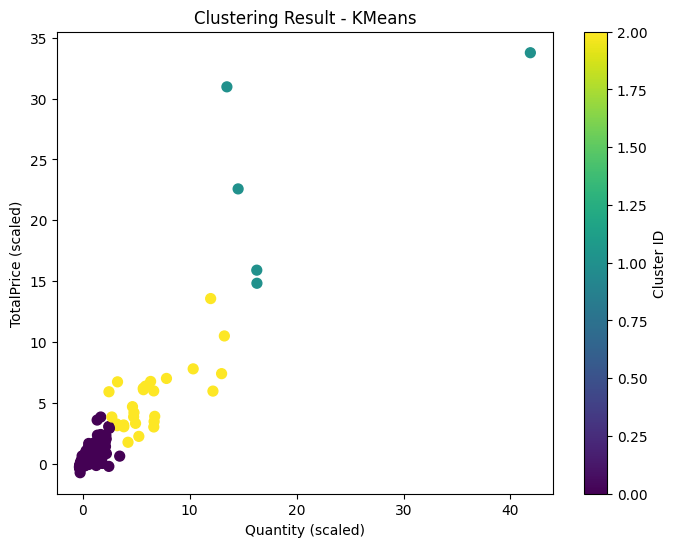

Silhouette Score for KMeans: 0.956
Calinski-Harabasz Index for KMeans: 7372.881


Evaluating DBSCAN Model


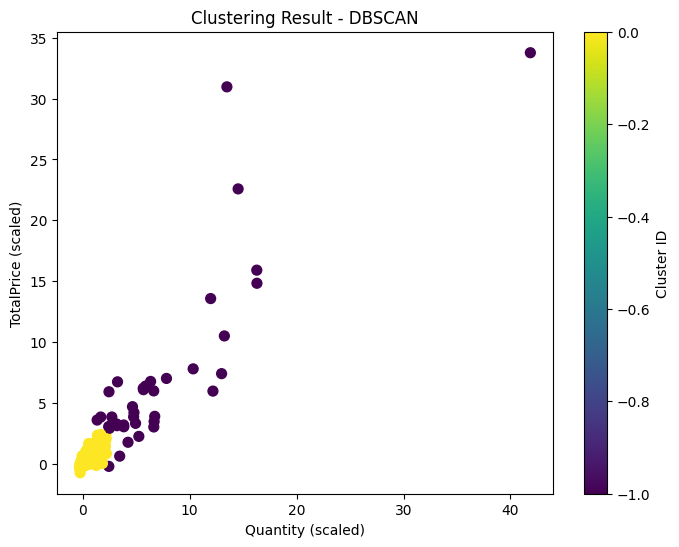

Silhouette Score for DBSCAN: 0.962
Calinski-Harabasz Index for DBSCAN: 3999.554


Evaluating AgglomerativeClustering Model


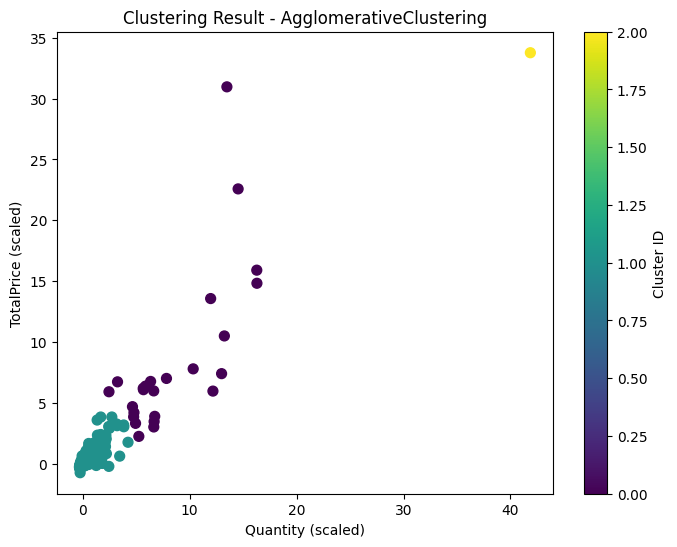

Silhouette Score for AgglomerativeClustering: 0.967
Calinski-Harabasz Index for AgglomerativeClustering: 6053.546




In [11]:
# Step 5: Evaluasi Clustering dan Visualisasi untuk Setiap Model
for model, model_name in zip(models, model_names):
    print(f"Evaluating {model_name} Model")
    evaluate_clustering(model, customer_data_scaled, model_name)
    print("\n")

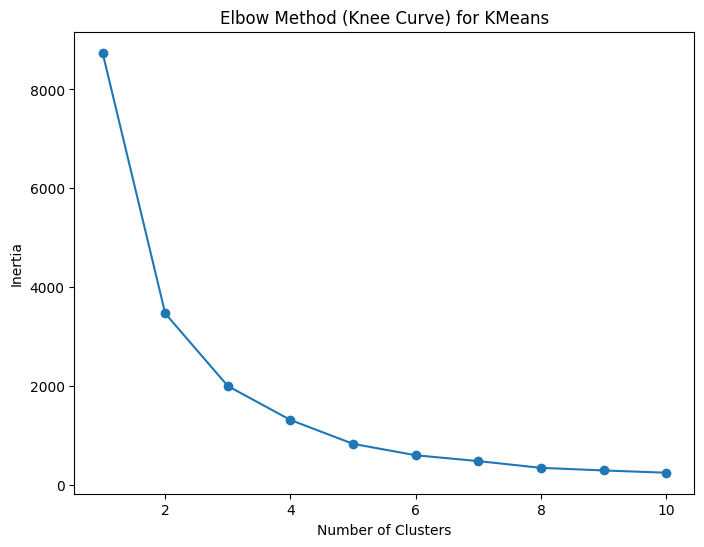

In [12]:
# Step 6: Knee Curve untuk Menentukan Jumlah Cluster Optimal pada KMeans
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)

# Plot Knee Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method (Knee Curve) for KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [13]:
# Step 7: Eksplorasi Metrik Evaluasi Tambahan - Adjusted Rand Index (ARI)
# Misalnya jika ada label ground truth untuk CustomerID, kita bisa gunakan ARI.
# Karena dataset ini tidak memiliki ground truth label, ARI mungkin tidak bisa dihitung.

# Menyimpan hasil clustering untuk perbandingan jika ada ground truth (contoh, kita hanya simpan hasil KMeans)
# Jika label ground truth tersedia, kita bisa hitung ARI untuk hasil model ini.
# ari_score = adjusted_rand_score(true_labels, clusters)  # true_labels perlu ditentukan

Evaluating KMeans
Evaluation Metrics for KMeans:
  - Silhouette Score: 0.9561031477840037
  - Calinski-Harabasz Index: 7372.881342197374
  - Davies-Bouldin Index: 0.5763144742797394


Evaluating DBSCAN
Evaluation Metrics for DBSCAN:
  - Silhouette Score: 0.9619923505221627
  - Calinski-Harabasz Index: 3999.553589770169
  - Davies-Bouldin Index: 0.6924887535886189


Evaluating AgglomerativeClustering
Evaluation Metrics for AgglomerativeClustering:
  - Silhouette Score: 0.9673505120500465
  - Calinski-Harabasz Index: 6053.546241948957
  - Davies-Bouldin Index: 0.41438974733528805




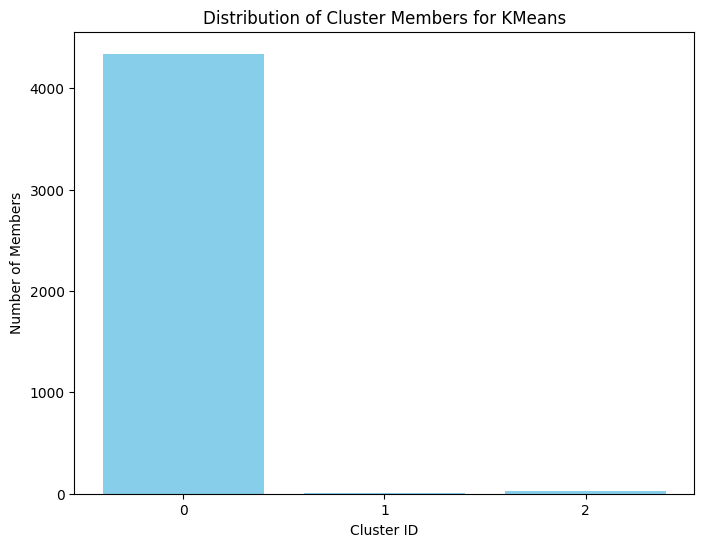

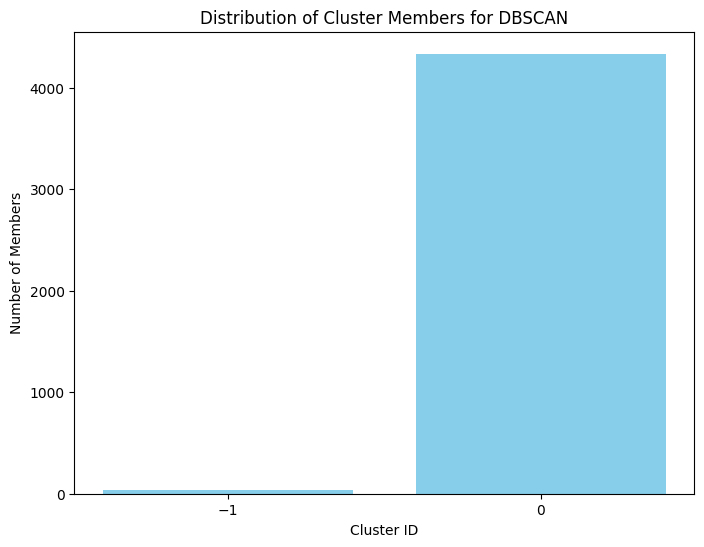

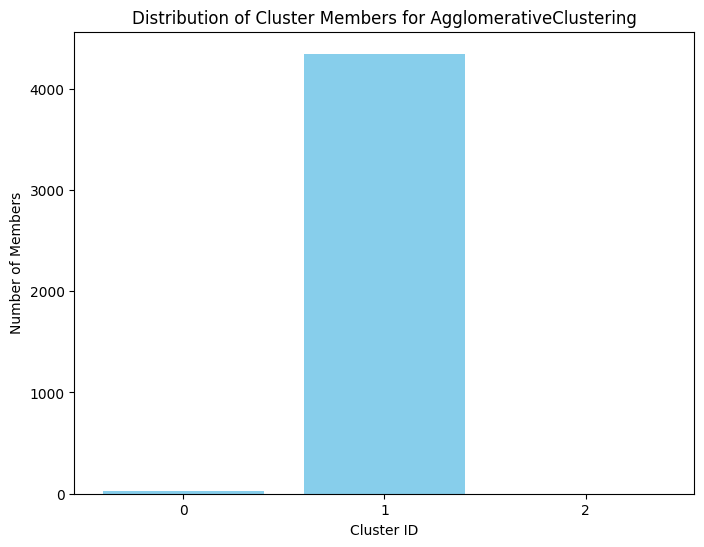


Summary of Clustering Evaluation Metrics:
                         Silhouette Score  Calinski-Harabasz Index  \
KMeans                           0.956103              7372.881342   
DBSCAN                           0.961992              3999.553590   
AgglomerativeClustering          0.967351              6053.546242   

                         Davies-Bouldin Index  
KMeans                               0.576314  
DBSCAN                               0.692489  
AgglomerativeClustering              0.414390  


In [14]:
# Fungsi untuk mengevaluasi dan menampilkan hasil clustering lebih detail
def detailed_evaluation(model, data, model_name):
    clusters = model.fit_predict(data)

    # Hitung Silhouette Score (jika memungkinkan)
    if len(set(clusters)) > 1:
        silhouette = silhouette_score(data, clusters)
    else:
        silhouette = None

    # Hitung Calinski-Harabasz Index
    if len(set(clusters)) > 1:
        ch_score = calinski_harabasz_score(data, clusters)
    else:
        ch_score = None

    # Hitung Davies-Bouldin Index
    if len(set(clusters)) > 1:
        db_score = davies_bouldin_score(data, clusters)
    else:
        db_score = None

    print(f"Evaluation Metrics for {model_name}:")
    print(f"  - Silhouette Score: {silhouette if silhouette is not None else 'Not Calculable'}")
    print(f"  - Calinski-Harabasz Index: {ch_score if ch_score is not None else 'Not Calculable'}")
    print(f"  - Davies-Bouldin Index: {db_score if db_score is not None else 'Not Calculable'}")
    print("\n")

    return silhouette, ch_score, db_score, clusters

# Menjalankan evaluasi untuk setiap model dan menyimpan hasilnya
results = {}
for model, model_name in zip(models, model_names):
    print(f"Evaluating {model_name}")
    silhouette, ch_score, db_score, clusters = detailed_evaluation(model, customer_data_scaled, model_name)
    results[model_name] = {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Index': ch_score,
        'Davies-Bouldin Index': db_score,
        'Clusters': clusters
    }

# Step 8.1: Visualisasi Distribusi Jumlah Anggota di Tiap Cluster
for model_name, result in results.items():
    clusters = result['Clusters']
    unique, counts = np.unique(clusters, return_counts=True)

    plt.figure(figsize=(8, 6))
    plt.bar(unique, counts, color='skyblue')
    plt.title(f'Distribution of Cluster Members for {model_name}')
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Members')
    plt.xticks(unique)
    plt.show()

# Ringkasan hasil evaluasi clustering
print("\nSummary of Clustering Evaluation Metrics:")
summary_df = pd.DataFrame.from_dict(results, orient='index', columns=['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'])
print(summary_df)

In [16]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset dari Google Drive
import pandas as pd

# Ganti path berikut dengan path lengkap menuju file "clusteringweek06.csv"
file_path = '/content/drive/MyDrive/clusteringweek06.csv'
dataset = pd.read_csv(file_path)

# Menampilkan lima baris pertama untuk memeriksa data
print(dataset.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
    x1        x2        x3        x4        x5        x6        x7        x8  \
0  1.0  0.152936 -0.105586  0.200722  0.317201  0.260764  0.100945 -0.150063   
1  1.0  0.171534 -0.098975  0.268425  0.338672  0.268353  0.060835 -0.222475   
2  1.0  0.152317 -0.082973  0.287128  0.276014  0.189867  0.008714 -0.242234   
3  1.0  0.224392  0.118985  0.329432  0.372088  0.361005  0.015501 -0.194347   
4  1.0  0.087817 -0.068345  0.306967  0.330923  0.249144  0.006884 -0.265423   

         x9       x10  ...       x13       x14       x15       x16       x17  \
0 -0.171128  0.124676  ... -0.156436  0.082245  0.135752 -0.024017 -0.108351   
1 -0.207693  0.170883  ... -0.254341  0.022786  0.163320  0.012022 -0.090974   
2 -0.219153  0.232538  ... -0.237384  0.050791  0.207338  0.083536 -0.050691   
3 -0.098181  0.270375  ... -0.317084 -0.011567  0.100413 -0.050224 -0.

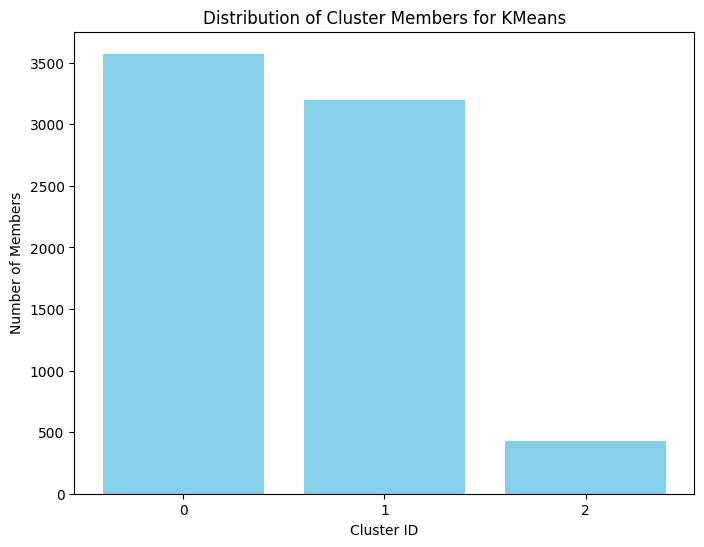

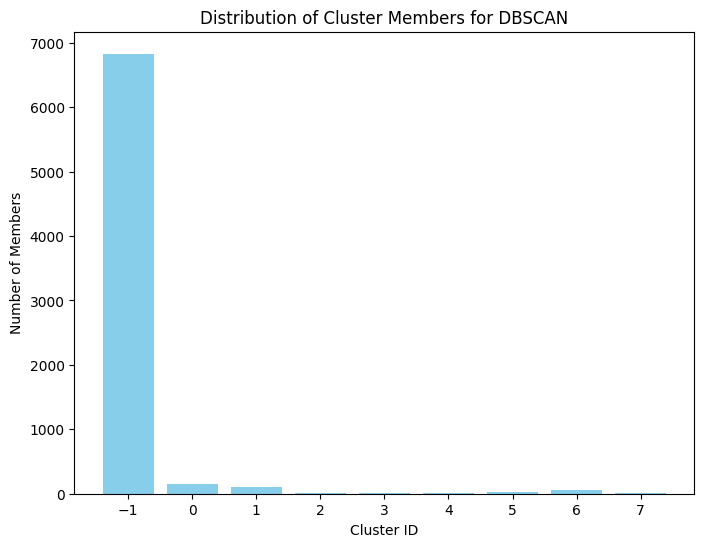

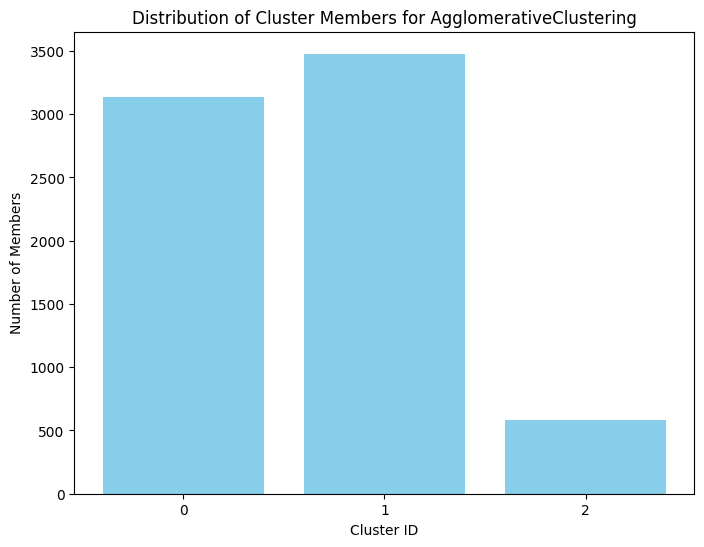


Summary of Clustering Evaluation Metrics:
                         Silhouette Score  Calinski-Harabasz Index  \
KMeans                           0.333652              2194.578237   
DBSCAN                          -0.227119                15.308951   
AgglomerativeClustering          0.349178              2329.629151   

                         Davies-Bouldin Index  
KMeans                               1.265539  
DBSCAN                               1.775392  
AgglomerativeClustering              1.456754  


In [17]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(dataset)

models = [
    KMeans(n_clusters=3, random_state=42),
    DBSCAN(eps=0.5, min_samples=5),
    AgglomerativeClustering(n_clusters=3)
]
model_names = ['KMeans', 'DBSCAN', 'AgglomerativeClustering']

results = {}
for model, model_name in zip(models, model_names):
    clusters = model.fit_predict(data_scaled)

    # Hitung evaluasi metrik: Silhouette, Calinski-Harabasz, Davies-Bouldin
    silhouette = silhouette_score(data_scaled, clusters) if len(set(clusters)) > 1 else None
    ch_score = calinski_harabasz_score(data_scaled, clusters) if len(set(clusters)) > 1 else None
    db_score = davies_bouldin_score(data_scaled, clusters) if len(set(clusters)) > 1 else None

    # Simpan hasil evaluasi
    results[model_name] = {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Index': ch_score,
        'Davies-Bouldin Index': db_score,
        'Clusters': clusters
    }

    # Visualisasi Distribusi Cluster
    unique, counts = np.unique(clusters, return_counts=True)
    plt.figure(figsize=(8, 6))
    plt.bar(unique, counts, color='skyblue')
    plt.title(f'Distribution of Cluster Members for {model_name}')
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Members')
    plt.xticks(unique)
    plt.show()

# Step 8: Ringkasan hasil evaluasi clustering
summary_df = pd.DataFrame.from_dict(results, orient='index', columns=['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'])
print("\nSummary of Clustering Evaluation Metrics:")
print(summary_df)